In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 0 — Setup
import os, json, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, confusion_matrix, classification_report)
from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
import itertools

RANDOM_STATE = 42

# Paths
BASE_PATH  = "/content/drive/MyDrive/heartriskx"
DATA_DIR   = f"{BASE_PATH}/data"
MODEL_DIR  = f"{BASE_PATH}/models/final"   # where your *_bundle.json and *_pipeline.joblib live
EXPORT_DIR = MODEL_DIR                      # same as above
OUT_DIR    = f"{BASE_PATH}/outputs/day9"
os.makedirs(OUT_DIR, exist_ok=True)

# plotting
plt.rcParams["figure.figsize"] = (7,5)
sns.set(style="whitegrid")

print("Using:\n", DATA_DIR, "\n", MODEL_DIR, "\n", OUT_DIR)


Using:
 /content/drive/MyDrive/heartriskx/data 
 /content/drive/MyDrive/heartriskx/models/final 
 /content/drive/MyDrive/heartriskx/outputs/day9


In [ ]:
# Cell 1 — Load datasets
base_path = DATA_DIR

# Heart2020
heart2020 = pd.read_csv(f"{base_path}/heart_2020.csv")
heart2020['target'] = heart2020['HeartDisease'].map({'Yes':1,'No':0}).astype(int)
heart2020 = heart2020.drop(columns=['HeartDisease'])

# Cardio
cardio = pd.read_csv(f"{base_path}/cardio_train.csv", sep=';')
cardio = cardio.rename(columns={'cardio':'target'})

# UCI (raw)
uci = pd.read_csv(f"{base_path}/uci_heart.csv", header=None)
uci.columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "target"
]
uci['target'] = (uci['target'] > 0).astype(int)

print("Heart2020:", heart2020.shape, "target:", heart2020['target'].value_counts().to_dict())
print("Cardio   :", cardio.shape,    "target:", cardio['target'].value_counts().to_dict())
print("UCI      :", uci.shape,       "target:", uci['target'].value_counts().to_dict())


Heart2020: (319795, 18) target: {0: 292422, 1: 27373}
Cardio   : (70000, 13) target: {0: 35021, 1: 34979}
UCI      : (303, 14) target: {0: 164, 1: 139}


In [ ]:
# Cell 2 — Helpers
def report_metrics(y_true, proba, thr=0.5):
    y_pred = (proba >= thr).astype(int)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, proba),
        "pr_auc": average_precision_score(y_true, proba)
    }, y_pred

def print_metrics_table(name, m):
    print(f"{name}: Acc={m['accuracy']:.3f}, Prec={m['precision']:.3f}, Rec={m['recall']:.3f}, "
          f"F1={m['f1']:.3f}, ROC-AUC={m['roc_auc']:.3f}, PR-AUC={m['pr_auc']:.3f}")

def plot_confusion(y_true, y_pred, title, savepath=None):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title); plt.xlabel("Predicted"); plt.ylabel("Actual")
    if savepath: plt.savefig(savepath, bbox_inches="tight")
    plt.show(); plt.close()

def best_f1_threshold(y_true, proba):
    from sklearn.metrics import precision_recall_curve
    prec, rec, th = precision_recall_curve(y_true, proba)
    f1 = 2*prec*rec/(prec+rec + 1e-12)
    i = np.nanargmax(f1)
    return float(th[i]) if i < len(th) else 0.5, float(f1[i]), float(prec[i]), float(rec[i])


In [ ]:
# Cell 3 — Load final pipelines
def load_bundle(prefix):
    bundle_path = os.path.join(EXPORT_DIR, f"{prefix}_bundle.json")
    if not os.path.exists(bundle_path):
        raise FileNotFoundError(bundle_path)
    with open(bundle_path, "r") as f:
        info = json.load(f)
    pipe = joblib.load(info["pipeline_path"])
    thr  = info.get("threshold", 0.5)
    return pipe, thr

models = {}
for prefix in ["heart2020", "cardio", "uci"]:
    try:
        pipe, thr = load_bundle(prefix)
        models[prefix] = {"pipe": pipe, "thr": thr}
        print("Loaded:", prefix, "thr=", thr)
    except Exception as e:
        print("Couldn't load bundle for", prefix, "->", e)


Loaded: heart2020 thr= 0.723115550317454
Loaded: cardio thr= 0.38848665919874714
Loaded: uci thr= 0.4891037479162372


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



heart2020 @0.5
heart2020 @0.5: Acc=0.732, Prec=0.215, Rec=0.806, F1=0.339, ROC-AUC=0.840, PR-AUC=0.351
heart2020 best thr (test)=0.744 (F1=0.397)
heart2020 @best: Acc=0.876, Prec=0.339, Rec=0.479, F1=0.397, ROC-AUC=0.840, PR-AUC=0.351


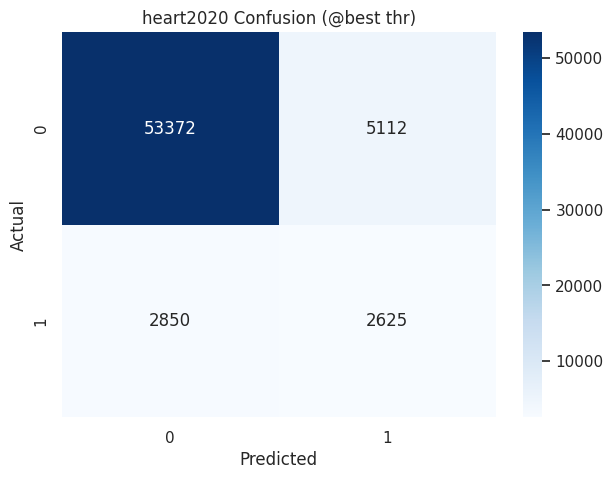

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



cardio @0.5
cardio @0.5: Acc=0.735, Prec=0.754, Rec=0.697, F1=0.724, ROC-AUC=0.800, PR-AUC=0.784
cardio best thr (test)=0.350 (F1=0.742)
cardio @best: Acc=0.707, Prec=0.663, Rec=0.842, F1=0.742, ROC-AUC=0.800, PR-AUC=0.784


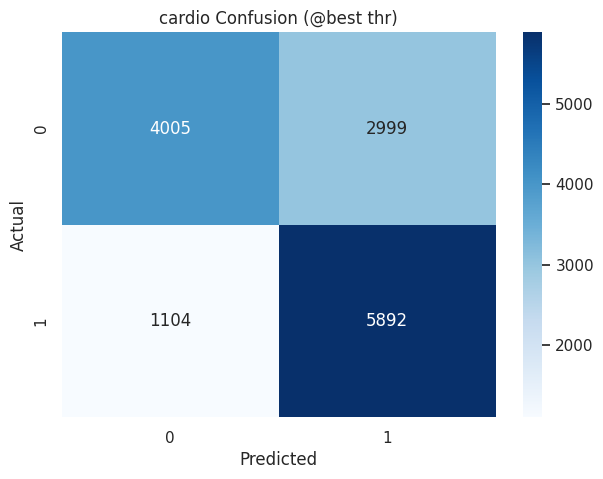


uci @0.5
uci @0.5: Acc=0.885, Prec=0.839, Rec=0.929, F1=0.881, ROC-AUC=0.948, PR-AUC=0.945
uci best thr (test)=0.573 (F1=0.897)
uci @best: Acc=0.902, Prec=0.867, Rec=0.929, F1=0.897, ROC-AUC=0.948, PR-AUC=0.945


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


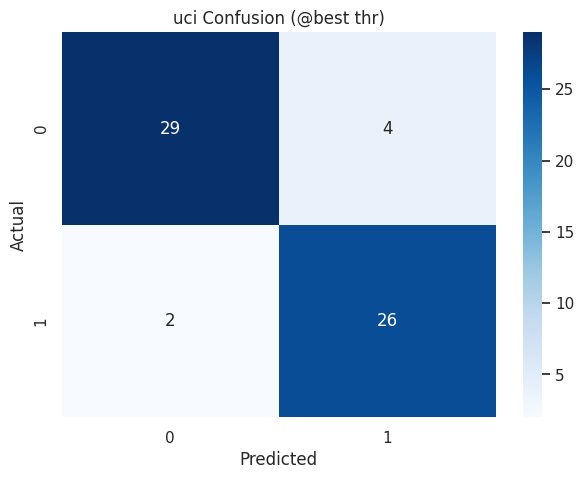


Saved: /content/drive/MyDrive/heartriskx/outputs/day9/day9_self_eval_summary.csv


In [ ]:
# Cell 4 — Per-dataset self eval (new 80/20 split for a quick check)
results = {}
for name, df in [("heart2020", heart2020), ("cardio", cardio), ("uci", uci)]:
    X = df.drop(columns=["target"]); y = df["target"]
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

    if name not in models:
        print("No model for", name); continue

    pipe = models[name]["pipe"]; thr = models[name]["thr"]
    proba = pipe.predict_proba(X_te)[:,1]

    thr_best, f1b, pb, rb = best_f1_threshold(y_te, proba)
    m50, _   = report_metrics(y_te, proba, 0.5)
    mbest, y_pred_best = report_metrics(y_te, proba, thr_best)

    results[name] = {"m50": m50, "mbest": mbest, "best_thr": thr_best, "best_f1": f1b}
    print(f"\n{name} @0.5");  print_metrics_table(name+" @0.5", m50)
    print(f"{name} best thr (test)={thr_best:.3f} (F1={f1b:.3f})")
    print_metrics_table(name+" @best", mbest)

    plot_confusion(y_te, y_pred_best, f"{name} Confusion (@best thr)",
                   savepath=os.path.join(OUT_DIR, f"{name}_confusion_best.png"))

# Save summary CSV
rows = []
for k,v in results.items():
    r = {"dataset":k, "best_thr": v["best_thr"]}
    for k2, k3 in v["m50"].items():   r["@0.5_"+k2]  = float(k3)
    for k2, k3 in v["mbest"].items(): r["@best_"+k2] = float(k3)
    rows.append(r)
pd.DataFrame(rows).to_csv(os.path.join(OUT_DIR, "day9_self_eval_summary.csv"), index=False)
print("\nSaved:", os.path.join(OUT_DIR, "day9_self_eval_summary.csv"))


In [ ]:
# Cell 5b — Cross-dataset on a shared schema (HARM_COLS) with strict dtype alignment

# --- 1) Build harmonized views (for reporting only) ---
def build_harmonized(df, dataset_name):
    if dataset_name == "cardio":
        out = pd.DataFrame({
            "age_years": (df["age"]/365.25).astype(float),
            "sex_male":  (df["gender"]==2).astype(int),
            "bmi":       (df["weight"] / (df["height"]/100.0)**2).astype(float),
            "sbp":       pd.to_numeric(df["ap_hi"], errors="coerce"),
            "dbp":       pd.to_numeric(df["ap_lo"], errors="coerce"),
            "chol_high": (df["cholesterol"]>=2).astype(int),
            "gluc_high": (df["gluc"]>=2).astype(int),
            "smoke":     df["smoke"].astype(int),
            "alco":      df["alco"].astype(int),
            "active":    df["active"].astype(int),
        })
        out["target"] = df["target"].astype(int)
        return out

    if dataset_name == "heart2020":
        sex_male = df["Sex"].astype(str).str.lower().eq("male").astype(int)
        chol_high = df["GenHealth"].astype(str).str.lower().isin(["fair","poor"]).astype(int)
        gluc_high = df["Diabetic"].astype(str).str.lower().eq("yes").astype(int)
        smoke = df["Smoking"].astype(str).str.lower().eq("yes").astype(int)
        alco  = df["AlcoholDrinking"].astype(str).str.lower().eq("yes").astype(int)
        active= df["PhysicalActivity"].astype(str).str.lower().eq("yes").astype(int)
        out = pd.DataFrame({
            "age_years": np.nan,
            "sex_male":  sex_male,
            "bmi":       pd.to_numeric(df["BMI"], errors="coerce"),
            "sbp":       np.nan,
            "dbp":       np.nan,
            "chol_high": chol_high,
            "gluc_high": gluc_high,
            "smoke":     smoke,
            "alco":      alco,
            "active":    active,
        })
        out["target"] = df["target"].astype(int)
        return out

    if dataset_name == "uci":
        out = pd.DataFrame({
            "age_years": pd.to_numeric(df["age"], errors="coerce"),
            "sex_male":  df["sex"].astype(int),
            "bmi":       np.nan,
            "sbp":       pd.to_numeric(df["trestbps"], errors="coerce"),
            "dbp":       np.nan,
            "chol_high": (pd.to_numeric(df["chol"], errors="coerce") > 240).astype(int),
            "gluc_high": np.nan,
            "smoke":     np.nan,
            "alco":      np.nan,
            "active":    np.nan,
        })
        out["target"] = df["target"].astype(int)
        return out

    raise ValueError("Unknown dataset name")

h_heart = build_harmonized(heart2020.copy(), "heart2020")
h_card  = build_harmonized(cardio.copy(),    "cardio")
h_uci   = build_harmonized(uci.copy(),       "uci")

# --- 2) STRICT raw alignment: infer numeric/cat roles from pipeline, coerce types, fill, order ---
def get_cols_by_role(prep):
    num_cols, cat_cols = [], []
    try:
        for name, transformer, cols in prep.transformers_:
            if name == "num":
                num_cols += list(cols)
            elif name == "cat":
                cat_cols += list(cols)
        # de-dup preserving order
        seen=set(); num_cols=[c for c in num_cols if not (c in seen or seen.add(c))]
        seen=set(); cat_cols=[c for c in cat_cols if not (c in seen or seen.add(c))]
        return num_cols, cat_cols
    except Exception:
        return None, None

def expected_raw_order(prep):
    num_cols, cat_cols = get_cols_by_role(prep)
    if num_cols is None: return None
    return list(num_cols) + list(cat_cols)

def align_and_predict_strict(pipe, X_target):
    """
    Use pipeline's ColumnTransformer to:
    - add missing numeric cols (0.0) & categorical cols ('missing')
    - coerce numeric -> float; categorical -> string
    - reorder columns to num + cat
    """
    prep = pipe.named_steps.get("prep", None)
    if prep is None:
        # No preprocessor—assume raw matches
        return pipe.predict_proba(X_target)[:,1], {"note":"no-prep"}

    num_cols, cat_cols = get_cols_by_role(prep)
    order = expected_raw_order(prep)
    if order is None:
        # fallback: best effort
        return pipe.predict_proba(X_target)[:,1], {"note":"no-schema-read"}

    X = X_target.copy()

    # Add missing with safe defaults
    for c in num_cols:
        if c not in X.columns: X[c] = 0.0
    for c in cat_cols:
        if c not in X.columns: X[c] = "missing"

    # Coerce dtypes
    for c in num_cols:
        X[c] = pd.to_numeric(X[c], errors="coerce").fillna(0.0).astype(float)
    for c in cat_cols:
        # ensure pure string dtype (OneHotEncoder/OrdinalEncoder-safe)
        X[c] = X[c].astype("string").fillna("missing")

    # Reindex to exact expected order (drop extras)
    X = X.reindex(columns=order)

    # Predict
    return pipe.predict_proba(X)[:,1], {"added_num":[c for c in num_cols if c not in X_target.columns],
                                        "added_cat":[c for c in cat_cols if c not in X_target.columns]}

# --- 3) Cross-dataset using strict alignment (models still use their native raw schema) ---
pairs = [("cardio","uci"), ("cardio","heart2020"),
         ("heart2020","cardio"), ("heart2020","uci"),
         ("uci","cardio"), ("uci","heart2020")]

raw_frames  = {"heart2020":heart2020, "cardio":cardio, "uci":uci}
harm_frames = {"heart2020":h_heart,   "cardio":h_card,  "uci":h_uci}

def attempt_predict_on_harmonized(models, src, tgt):
    if src not in models:
        return {"trained_on":src,"tested_on":tgt,"error":"model missing"}
    pipe, thr_used = models[src]["pipe"], models[src]["thr"]

    X_raw = raw_frames[tgt].drop(columns=["target"])
    y_t   = raw_frames[tgt]["target"].astype(int)

    # Strict align raw → predict
    proba, info = align_and_predict_strict(pipe, X_raw)

    m_used, _ = report_metrics(y_t, proba, thr_used)
    from sklearn.metrics import precision_recall_curve
    prec, rec, th = precision_recall_curve(y_t, proba)
    f1 = 2*prec*rec/(prec+rec+1e-12)
    i  = np.nanargmax(f1)
    best_thr = float(th[i]) if i < len(th) else 0.5
    m_best, _ = report_metrics(y_t, proba, best_thr)

    return {
        "trained_on":src, "tested_on":tgt, "thr_used":thr_used,
        "acc_at_used_thr":m_used["accuracy"], "f1_at_used_thr":m_used["f1"],
        "acc_at_best_thr":m_best["accuracy"], "f1_at_best_thr":m_best["f1"],
        "best_thr_on_test":best_thr,
        "added_num": ";".join(info.get("added_num",[])),
        "added_cat": ";".join(info.get("added_cat",[]))
    }

cross_rows=[]
for src,tgt in pairs:
    print(f"\n▶️ {src} → {tgt} (strict dtype alignment)")
    try:
        row = attempt_predict_on_harmonized(models, src, tgt)
        cross_rows.append(row)
        print(f"{src}->{tgt} @used_thr({row['thr_used']:.3f}): F1={row['f1_at_used_thr']:.3f}, Acc={row['acc_at_used_thr']:.3f}")
        print(f"{src}->{tgt} @best_thr({row['best_thr_on_test']:.3f}): F1={row['f1_at_best_thr']:.3f}, Acc={row['acc_at_best_thr']:.3f}")
        if row.get("added_num") or row.get("added_cat"):
            print("  added_num:", row.get("added_num","-"))
            print("  added_cat:", row.get("added_cat","-"))
    except Exception as e:
        print("  FAILED:", e)
        cross_rows.append({"trained_on":src,"tested_on":tgt,"error":str(e)})

pd.DataFrame(cross_rows).to_csv(os.path.join(OUT_DIR, "day9_harmonized_cross_dataset.csv"), index=False)
print("\nSaved:", os.path.join(OUT_DIR, "day9_harmonized_cross_dataset.csv"))



▶️ cardio → uci (strict dtype alignment)
cardio->uci @used_thr(0.388): F1=0.000, Acc=0.541
cardio->uci @best_thr(0.018): F1=0.629, Acc=0.459
  added_num: gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active
  added_cat: 

▶️ cardio → heart2020 (strict dtype alignment)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


cardio->heart2020 @used_thr(0.388): F1=0.000, Acc=0.914
cardio->heart2020 @best_thr(0.018): F1=0.158, Acc=0.086
  added_num: age;gender;height;weight;ap_hi;ap_lo;cholesterol;gluc;smoke;alco;active
  added_cat: 

▶️ heart2020 → cardio (strict dtype alignment)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


heart2020->cardio @used_thr(0.723): F1=0.666, Acc=0.500
heart2020->cardio @best_thr(0.928): F1=0.666, Acc=0.500
  added_num: BMI;PhysicalHealth;MentalHealth;SleepTime
  added_cat: Smoking;AlcoholDrinking;Stroke;DiffWalking;Sex;AgeCategory;Race;Diabetic;PhysicalActivity;GenHealth;Asthma;KidneyDisease;SkinCancer

▶️ heart2020 → uci (strict dtype alignment)
heart2020->uci @used_thr(0.723): F1=0.629, Acc=0.459
heart2020->uci @best_thr(0.928): F1=0.629, Acc=0.459
  added_num: BMI;PhysicalHealth;MentalHealth;SleepTime
  added_cat: Smoking;AlcoholDrinking;Stroke;DiffWalking;Sex;AgeCategory;Race;Diabetic;PhysicalActivity;GenHealth;Asthma;KidneyDisease;SkinCancer

▶️ uci → cardio (strict dtype alignment)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


uci->cardio @used_thr(0.489): F1=0.000, Acc=0.500
uci->cardio @best_thr(0.107): F1=0.666, Acc=0.500
  added_num: sex;cp;trestbps;chol;fbs;restecg;thalach;exang;oldpeak;slope
  added_cat: ca;thal

▶️ uci → heart2020 (strict dtype alignment)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


uci->heart2020 @used_thr(0.489): F1=0.000, Acc=0.914
uci->heart2020 @best_thr(0.100): F1=0.158, Acc=0.086
  added_num: age;sex;cp;trestbps;chol;fbs;restecg;thalach;exang;oldpeak;slope
  added_cat: ca;thal

Saved: /content/drive/MyDrive/heartriskx/outputs/day9/day9_harmonized_cross_dataset.csv


In [ ]:
# Cell 6 — Failure examples per dataset (using model's native thr)
def show_failure_examples(pipe, X, y, thr, n=3):
    proba = pipe.predict_proba(X)[:,1]
    preds = (proba >= thr).astype(int)
    df = X.copy()
    df["_true"] = y.values
    df["_proba"] = proba
    df["_pred"] = preds
    fn = df[(df["_true"]==1) & (df["_pred"]==0)].sort_values("_proba", ascending=False).head(n)
    fp = df[(df["_true"]==0) & (df["_pred"]==1)].sort_values("_proba", ascending=True).head(n)
    return fn, fp

for name in models:
    pipe = models[name]["pipe"]; thr = models[name]["thr"]
    df = {"heart2020":heart2020, "cardio":cardio, "uci":uci}[name]
    X = df.drop(columns=["target"]); y = df["target"]
    fn, fp = show_failure_examples(pipe, X, y, thr, n=3)
    print("\n=== Failure samples for", name, "===")
    print("False Negatives:")
    display(fn.drop(columns=["_true","_proba","_pred"]))
    print("False Positives:")
    display(fp.drop(columns=["_true","_proba","_pred"]))
    fn.to_csv(os.path.join(OUT_DIR, f"{name}_false_negatives_sample.csv"), index=False)
    fp.to_csv(os.path.join(OUT_DIR, f"{name}_false_positives_sample.csv"), index=False)

print("\nSaved FP/FN samples to:", OUT_DIR)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Failure samples for heart2020 ===
False Negatives:


,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
302512,31.09,Yes,No,No,30.0,10.0,Yes,Female,55-59,White,No,No,Poor,6.0,No,No,No
145032,36.92,No,No,No,0.0,0.0,No,Male,75-79,White,Yes,No,Very good,8.0,No,No,No
170727,39.33,No,No,No,0.0,0.0,No,Male,75-79,White,Yes,Yes,Very good,8.0,No,No,No


False Positives:


,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
222264,21.46,No,No,No,20.0,25.0,Yes,Female,80 or older,White,No,No,Good,6.0,No,No,No
247237,31.01,No,No,No,30.0,7.0,No,Male,50-54,White,Yes,Yes,Fair,4.0,No,No,Yes
120098,31.10,Yes,No,No,0.0,0.0,No,Male,65-69,Black,Yes,No,Fair,8.0,No,No,No


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



=== Failure samples for cardio ===
False Negatives:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
38954,55614,21175,1,160,60.0,120,80,1,1,0,0,1
47381,67675,21149,1,160,60.0,120,80,1,1,0,0,1
9221,13139,21162,1,160,60.0,120,80,1,1,0,0,1


False Positives:


,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
56646,80865,20490,1,158,78.0,120,80,1,1,0,0,1
52086,74295,20436,1,166,88.0,120,80,1,1,0,0,1
63950,91297,20229,2,167,83.0,120,80,1,1,0,0,1



=== Failure samples for uci ===
False Negatives:


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
231,55.0,0.0,4.0,180.0,327.0,0.0,1.0,117.0,1.0,3.4,2.0,0.0,3.0
66,60.0,1.0,3.0,140.0,185.0,0.0,2.0,155.0,0.0,3.0,2.0,0.0,3.0


False Positives:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
186,42.0,1.0,3.0,120.0,240.0,1.0,0.0,194.0,0.0,0.8,3.0,0.0,7.0
183,59.0,1.0,1.0,178.0,270.0,0.0,2.0,145.0,0.0,4.2,3.0,0.0,7.0
176,52.0,1.0,4.0,108.0,233.0,1.0,0.0,147.0,0.0,0.1,1.0,3.0,7.0



Saved FP/FN samples to: /content/drive/MyDrive/heartriskx/outputs/day9


In [ ]:
# Cell 7 — Add noise to numeric columns and re-evaluate
def numeric_cols_from_df(X):
    return X.select_dtypes(include=[np.number]).columns.tolist()

robust_rows = []
for name in models:
    pipe = models[name]["pipe"]; thr = models[name]["thr"]
    df = {"heart2020":heart2020, "cardio":cardio, "uci":uci}[name]
    X = df.drop(columns=["target"]); y = df["target"]

    num_cols = numeric_cols_from_df(X)
    for noise_frac in [0.05, 0.10, 0.20]:
        Xn = X.copy()
        for c in num_cols:
            sd = Xn[c].astype(float).std()
            Xn[c] = pd.to_numeric(Xn[c], errors='coerce').fillna(0.0) + np.random.normal(0, sd*noise_frac, size=len(Xn))
        proba = pipe.predict_proba(Xn)[:,1]
        m, _ = report_metrics(y, proba, thr)
        robust_rows.append({"dataset":name, "noise_frac":noise_frac, **m})
        print(f"{name} noise {noise_frac:.2f} → F1={m['f1']:.3f}, ROC-AUC={m['roc_auc']:.3f}")

pd.DataFrame(robust_rows).to_csv(os.path.join(OUT_DIR, "day9_noise_robustness.csv"), index=False)
print("\nSaved:", os.path.join(OUT_DIR, "day9_noise_robustness.csv"))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


heart2020 noise 0.05 → F1=0.407, ROC-AUC=0.850


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


heart2020 noise 0.10 → F1=0.407, ROC-AUC=0.850


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


heart2020 noise 0.20 → F1=0.406, ROC-AUC=0.849


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


cardio noise 0.05 → F1=0.714, ROC-AUC=0.784


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


cardio noise 0.10 → F1=0.696, ROC-AUC=0.740


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


cardio noise 0.20 → F1=0.671, ROC-AUC=0.668
uci noise 0.05 → F1=0.947, ROC-AUC=0.985
uci noise 0.10 → F1=0.926, ROC-AUC=0.976
uci noise 0.20 → F1=0.908, ROC-AUC=0.969

Saved: /content/drive/MyDrive/heartriskx/outputs/day9/day9_noise_robustness.csv


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# Cell 8 — Drop top-k features (best-effort; will skip if pipeline insists on all cols)
def get_feature_importance(pipe):
    try:
        clf = pipe.named_steps["clf"]
        cols = pipe.named_steps["prep"].get_feature_names_out()
        if hasattr(clf, "feature_importances_"):
            imp = clf.feature_importances_
            return pd.DataFrame({"feature": cols, "imp": imp}).sort_values("imp", ascending=False)
    except Exception:
        pass
    return None

drop_rows = []
for name in models:
    pipe = models[name]["pipe"]; thr = models[name]["thr"]
    df = {"heart2020":heart2020, "cardio":cardio, "uci":uci}[name]
    X = df.drop(columns=["target"]); y = df["target"]
    fi = get_feature_importance(pipe)
    if fi is None:
        print("Skipping drop test for", name, "(no importances)")
        continue

    # Map transformed features back to raw columns best-effort: if OHE, names look like 'cat__Feature_Value'
    top_feats = fi["feature"].head(8).tolist()
    raw_drop = sorted(set([t.split("__")[1].split("_")[0] if "__" in t else t for t in top_feats]))

    for k in [1,2,3]:
        drop_cols = raw_drop[:k]
        X_drop = X.drop(columns=[c for c in drop_cols if c in X.columns], errors='ignore')
        try:
            proba = pipe.predict_proba(X_drop)[:,1]
            m, _ = report_metrics(y, proba, thr)
            drop_rows.append({"dataset":name, "dropped_k":k, "f1":m["f1"], "roc_auc":m["roc_auc"]})
            print(f"{name} drop top-{k} raw cols {drop_cols} → F1={m['f1']:.3f}")
        except Exception as e:
            print(f"{name} drop top-{k} skipped (pipeline requires those cols) →", e)

pd.DataFrame(drop_rows).to_csv(os.path.join(OUT_DIR, "day9_drop_feature_robustness.csv"), index=False)
print("\nSaved:", os.path.join(OUT_DIR, "day9_drop_feature_robustness.csv"))


heart2020 drop top-1 skipped (pipeline requires those cols) → columns are missing: {'AgeCategory'}
heart2020 drop top-2 skipped (pipeline requires those cols) → columns are missing: {'AgeCategory', 'BMI'}
heart2020 drop top-3 skipped (pipeline requires those cols) → columns are missing: {'MentalHealth', 'AgeCategory', 'BMI'}
cardio drop top-1 skipped (pipeline requires those cols) → columns are missing: {'active'}
cardio drop top-2 skipped (pipeline requires those cols) → columns are missing: {'age', 'active'}
cardio drop top-3 skipped (pipeline requires those cols) → columns are missing: {'age', 'active'}
uci drop top-1 skipped (pipeline requires those cols) → columns are missing: {'age'}
uci drop top-2 skipped (pipeline requires those cols) → columns are missing: {'ca', 'age'}
uci drop top-3 skipped (pipeline requires those cols) → columns are missing: {'ca', 'chol', 'age'}

Saved: /content/drive/MyDrive/heartriskx/outputs/day9/day9_drop_feature_robustness.csv


In [ ]:
# Cell 9 — Bootstrap threshold stability (F1 CI at model's chosen threshold)
def bootstrap_f1_ci(y, proba, thr, n_boot=200, seed=RANDOM_STATE):
    rng = np.random.RandomState(seed)
    f1s = []
    yv = y.values
    for _ in range(n_boot):
        idx = rng.randint(0, len(yv), len(yv))
        yy  = yv[idx]; pp = proba[idx]
        pred = (pp >= thr).astype(int)
        f1s.append(f1_score(yy, pred, zero_division=0))
    return np.percentile(f1s, [2.5, 50, 97.5])

rows=[]
for name in models:
    pipe = models[name]["pipe"]; thr = models[name]["thr"]
    df = {"heart2020":heart2020, "cardio":cardio, "uci":uci}[name]
    X = df.drop(columns=["target"]); y = df["target"]
    proba = pipe.predict_proba(X)[:,1]
    ci_low, ci_med, ci_high = bootstrap_f1_ci(y, proba, thr, n_boot=200)
    rows.append({"dataset":name, "thr":thr, "f1_ci_low":ci_low, "f1_median":ci_med, "f1_ci_high":ci_high})
    print(f"{name}: thr={thr:.3f}, F1 CI = [{ci_low:.3f}, {ci_high:.3f}] (median {ci_med:.3f})")

pd.DataFrame(rows).to_csv(os.path.join(OUT_DIR, "day9_threshold_stability.csv"), index=False)
print("\nSaved:", os.path.join(OUT_DIR, "day9_threshold_stability.csv"))


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


heart2020: thr=0.723, F1 CI = [0.404, 0.412] (median 0.408)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


cardio: thr=0.388, F1 CI = [0.748, 0.754] (median 0.751)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


uci: thr=0.489, F1 CI = [0.942, 0.986] (median 0.966)

Saved: /content/drive/MyDrive/heartriskx/outputs/day9/day9_threshold_stability.csv


In [ ]:
# Cell 10 — Final checklist
for fname in ["day9_self_eval_summary.csv", "day9_harmonized_cross_dataset.csv",
              "day9_noise_robustness.csv", "day9_drop_feature_robustness.csv",
              "day9_threshold_stability.csv"]:
    p = os.path.join(OUT_DIR, fname)
    print("exists:" if os.path.exists(p) else "missing:", fname)

print("\nAll outputs saved in:", OUT_DIR)
print("Please share:")
print(" - day9_self_eval_summary.csv")
print(" - day9_harmonized_cross_dataset.csv")
print(" - day9_noise_robustness.csv")
print(" - day9_drop_feature_robustness.csv")
print(" - day9_threshold_stability.csv")
print(" - confusion PNGs: *_confusion_best.png")


exists: day9_self_eval_summary.csv
exists: day9_harmonized_cross_dataset.csv
exists: day9_noise_robustness.csv
exists: day9_drop_feature_robustness.csv
exists: day9_threshold_stability.csv

All outputs saved in: /content/drive/MyDrive/heartriskx/outputs/day9
Please share:
 - day9_self_eval_summary.csv
 - day9_harmonized_cross_dataset.csv
 - day9_noise_robustness.csv
 - day9_drop_feature_robustness.csv
 - day9_threshold_stability.csv
 - confusion PNGs: *_confusion_best.png
